## NS shop+ 홈쇼핑 매출 EDA
- 2019.01.01~2019.12.31
- 시간, 품목별 홈쇼핑 매출 데이터
- 일별 날씨 데이터

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 한글 폰트 오류 해결
from matplotlib import font_manager, rc 
font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" #폰트 파일의 위치
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)

In [7]:
data = pd.read_csv("./정리데이터/휴일추가까지.csv")

## 홈쇼핑 주문량과 날씨와의 연관성 확인
1. 각 지역별 날씨가 홈쇼핑 주문량에 주는 영향
    - 다른 지역들과 비교해보았을 때, 서울날씨 데이터와 주문량 간의 상관관계가 더 큼 -
    - 서울 날씨 데이터만 대표적으로 넣는 것도 괜찮은 방법
  
1. 어떤 날씨 요인이 주문량에 영향을 많이 주는 가
    - 비(강수량)
    - 최고, 최저 기온
    - 풍속

### 데이터 전처리

In [8]:
# 데이터 정제
places = ["강릉","광주","부산","수원","울산","대구","대전","서울","파주"] # 대표 지역들
weather = pd.read_excel("./날씨_실제/강릉날씨.xlsx")
row_num = weather.shape[0]
weather["지역"]=["강릉"]*row_num

# 모든 지역 날씨 데이터 세로로 합치기
for p in places[1:]:
    a=pd.read_excel(f"./날씨_실제/{p}날씨.xlsx")
    a["지역"]=[p]*row_num
    weather = pd.concat([weather, a], axis=0)

In [9]:
# "-" -> 0값으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].replace("-",0)
weather["신적설(cm)"]=weather["신적설(cm)"].replace("-",0)
weather["운량(1/10)"]=weather["운량(1/10)"].replace("-",0)

# object 형 float 형으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].astype(float)
weather["신적설(cm)"]=weather["신적설(cm)"].astype(float)
weather["운량(1/10)"]=weather["운량(1/10)"].astype(float)

### 데이터 시각화

In [136]:
# 서울 날씨과 강능, 부산 날씨로 칼럼별 주문량 상관성 확인 및 지역별 날씨의 영향도 확인
gang_weather = weather.loc[weather["지역"]=="강릉",:]
seoul_weather = weather.loc[weather["지역"]=="서울",:]
busan_weather = weather.loc[weather["지역"]=="부산",:]
suwon_weather = weather.loc[weather["지역"]=="수원",:]
sudogwon_weather = weather.loc[(weather["지역"]=="서울")|(weather["지역"]=="수원"),:]

# 홈쇼핑 데이터
#day_data = data.groupby(["날짜"]).mean() # 일별 주문량
day_data = data.copy() # 각 시간별 주문량

# 두 데이터를 합친 데이터
all_data = day_data.merge(weather, on="날짜")
all_data = all_data.groupby(["날짜"]).mean()

sudogwon_data = day_data.merge(sudogwon_weather, on="날짜")
sudogwon_data = sudogwon_data.groupby(["날짜"]).mean()

suwon_data = day_data.merge(suwon_weather, on="날짜")
seoul_data = day_data.merge(seoul_weather, on="날짜")
busan_data = day_data.merge(busan_weather, on="날짜")
gang_data = day_data.merge(gang_weather, on="날짜")

In [131]:
# 시각화를 용이하게 하기 위한 데이터 전처리 함수
def preprocessing(data, bins=4):
    # 강수유무, 눈유무는 0,1 로 -> 비가오거나 눈이 쌓이면 1, 비가 오지 않거나 눈이 쌓이지 않으면 0
    data["강수유무"]=True
    data.loc[data["강수량(mm)"]!=0,"강수유무"]=1
    data.loc[data["강수량(mm)"]==0,"강수유무"]=0

    data["눈유무"]=True
    data.loc[data["신적설(cm)"]!=0,"눈유무"]=1
    data.loc[data["신적설(cm)"]==0,"눈유무"]=0

    # 나머지 칼럼은 6구간으로 나누기
    cate_columns= ["평균기온","최고기온","최저기온",'평균풍속(m/s)','평균습도(%)', '운량(1/10)', '일조시간(Hr)',"강수량(mm)","신적설(cm)"]
    
    for col in cate_columns:
        data[col]=pd.cut(data[col],bins)

In [132]:
# 데이터 전처리
for d in [all_data, seoul_data, busan_data, gang_data, sudogwon_data]:
    preprocessing(d,4)

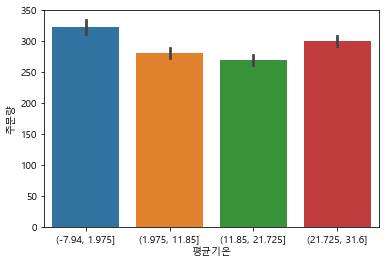

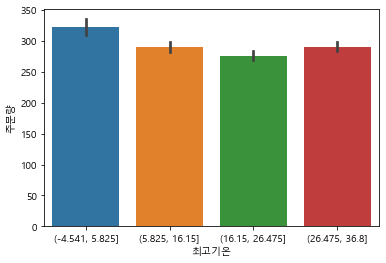

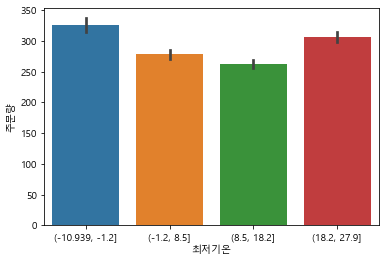

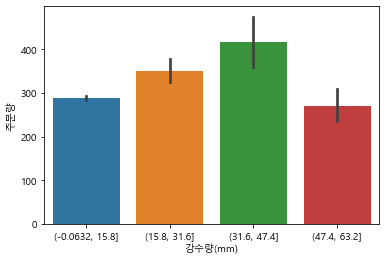

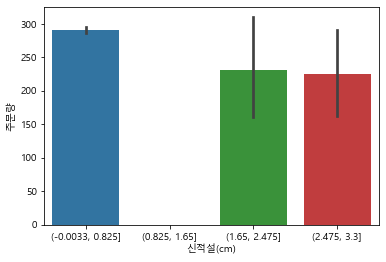

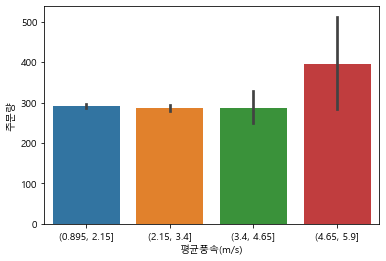

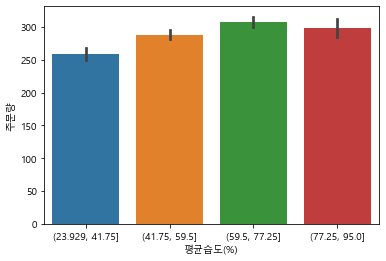

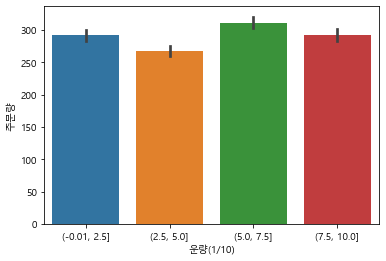

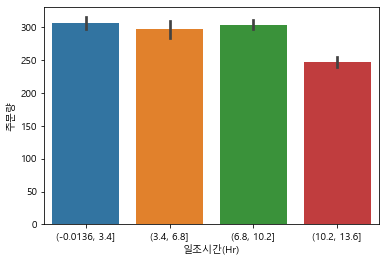

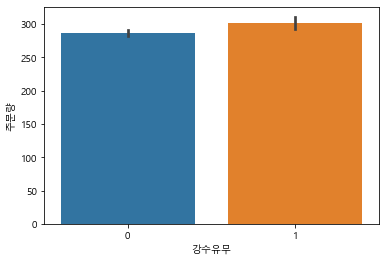

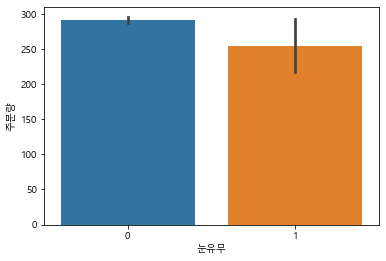

In [133]:
# 시각화
visual_columns = all_data.columns[9:] # 시각화를 원하는 칼럼

for col in visual_columns:
    sns.barplot(x=col, y="주문량", data=seoul_data)
    #plt.savefig(f'./날씨그래프/{col[:4]}.png') # 그래프 저장
    plt.show()
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


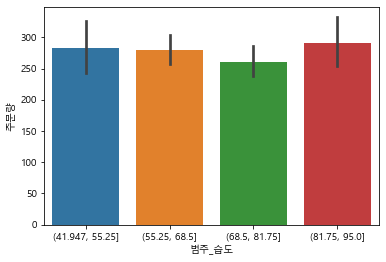

In [156]:
# 요일성을 제거하고 특정 월에 대해서만 시각화
seoul_data["월"]=pd.to_datetime(seoul_data["방송일시"]).dt.month
a = seoul_data.loc[((seoul_data["요일"]!=5)&(seoul_data["요일"]!=6))&(seoul_data["월"]==7),:]
a["범주_습도"]=pd.cut(a["평균습도(%)"],4)

sns.barplot(x="범주_습도", y="주문량", data=a)

In [16]:
display(all_data.iloc[:,7:].corr())
display(seoul_data.iloc[:,8:].corr())
display(busan_data.iloc[:,8:].corr())
display(gang_data.iloc[:,8:].corr())

# 다른 지역들과 비교해보았을 때, 서울날씨 데이터와 주문량 간의 상관관계가 더 큼 -> 서울 날씨 데이터만 대표적으로 넣는 것도 괜찮은 방법

,주문량,holiday
주문량,1.000000,-0.069701
holiday,-0.069701,1.000000


,요일,시,주문량,holiday
요일,1.000000,-0.002830,0.006296,-0.006835
시,-0.002830,1.000000,-0.081401,-0.002714
주문량,0.006296,-0.081401,1.000000,-0.014674
holiday,-0.006835,-0.002714,-0.014674,1.000000


,요일,시,주문량,holiday
요일,1.000000,-0.002830,0.006296,-0.006835
시,-0.002830,1.000000,-0.081401,-0.002714
주문량,0.006296,-0.081401,1.000000,-0.014674
holiday,-0.006835,-0.002714,-0.014674,1.000000


,요일,시,주문량,holiday
요일,1.000000,-0.002830,0.006296,-0.006835
시,-0.002830,1.000000,-0.081401,-0.002714
주문량,0.006296,-0.081401,1.000000,-0.014674
holiday,-0.006835,-0.002714,-0.014674,1.000000
